# Deep Policy-based Reinforcement Learning

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2023-students/master/logo.jpg" style="float: left; width: 15%" />

[INF639-2023](https://moodle.polytechnique.fr/course/view.php?id=17866) Lab session #2

2019-2023 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-inf639-2023-students/blob/master/lab2_deep_policy-based_reinforcement_learning.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf639-2023-students/master?filepath=lab2_deep_policy-based_reinforcement_learning.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-inf639-2023-students/blob/master/lab2_deep_policy-based_reinforcement_learning.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-inf639-2023-students/raw/master/lab2_deep_policy-based_reinforcement_learning.ipynb)

## Introduction

The aim of this lab is to provide an in-depth exploration of policy-based reinforcement learning techniques, with a particular focus on the *Monte Carlo Policy Gradient (REINFORCE)* and *Actor Critic* methods.

In this Python notebook, you'll have the opportunity to implement and assess several renowned Policy Gradient techniques.

You can either:
- open, edit and execute the notebook in *Google Colab* following this link: https://colab.research.google.com/github/jeremiedecock/polytechnique-inf639-2023-students/blob/master/lab2_deep_policy-based_reinforcement_learning.ipynb ; this is the **recommended** choice as you have nothing to install on your computer
- open, edit and execute the notebook in *MyBinder* (if for any reason the Google Colab solution doesn't work): https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf639-2023-students/master?filepath=lab2_deep_policy-based_reinforcement_learning.ipynb
- download, edit and execute the notebook on your computer if Python3 and JypyterLab are already installed: https://github.com/jeremiedecock/polytechnique-inf639-2023-students/raw/master/lab2_deep_policy-based_reinforcement_learning.ipynb

If you work with Google Colab or MyBinder, **remember to save or download your work regularly or you may lose it!**

## Setup the Python environment

### Install required libraries

**Note**: This notebook relies on several libraries including `PyTorch`, `Gymnasium`, `NumPy`, `Pandas`, `Seaborn`, `imageio`, `pygame`, and `tqdm`.
A complete list of dependencies can be found in the provided [requirements.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2023-students/master/requirements.txt) file.

If you are using Google Colab, the uncomment and execute the next cell to install dependencies.

In [ ]:
#! pip install inf581

If you are running this notebook on your local machine, download the [requirements.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2023-students/master/requirements.txt) file and place it in the same directory as this notebook. Then, execute the following command:

```
pip install -r requirements.txt
```

### Import required packages

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import random
import seaborn as sns
import torch
from torch.optim.lr_scheduler import _LRScheduler
from tqdm.notebook import tqdm
from typing import List, Tuple, Union

from inf581 import *

from IPython.display import Image   # To display GIF images in the notebook

In [2]:
sns.set_context("talk")

In [4]:
# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

Using device: cpu


## Part 1: Monte Carlo Policy Gradient (REINFORCE)

### The Policy Gradient theorem

We will solve the CartPole environment using a policy gradient method which directly searchs in a family of parameterized policies $\pi_\theta$ for the optimal policy.

This method performs gradient ascent in the policy space so that the total return is maximized.
We will restrict our work to episodic tasks, *i.e.* tasks that have a starting states and last for a finite and fixed number of steps $T$, called horizon.

More formally, we define an optimization criterion that we want to maximize:

$$J(\theta) = \mathbb{E}_{\pi_\theta}\left[\sum_{t=1}^T r(s_t,a_t)\right],$$

where $\mathbb{E}_{\pi_\theta}$ means $a \sim \pi_\theta(s,.)$ and $T$ is the horizon of the episode.
In other words, we want to maximize the value of the starting state: $V^{\pi_\theta}(s)$.
The policy gradient theorem tells us that:

$$
\nabla_\theta J(\theta) = \nabla_\theta V^{\pi_\theta}(s) = \mathbb{E}_{\pi_\theta} \left[\nabla_\theta \log \pi_\theta (s,a) ~ Q^{\pi_\theta}(s,a) \right],
$$

where the $Q$-function is defined as:

$$Q^{\pi_\theta}(s,a) = \mathbb{E}^{\pi_\theta} \left[\sum_{t=1}^T r(s_t,a_t)|s=s_1, a=a_1\right].$$

The policy gradient theorem is particularly effective because it allows gradient computation without needing to understand the system's dynamics, as long as the $Q$-function for the current policy is computable. By simply applying the policy and observing the one-step transitions, sufficient information is gathered. Implementing a stochastic gradient ascent and substituting $Q^{\pi_\theta}(s_t,a_t)$ with a Monte Carlo estimate $R_t = \sum_{t'=t}^T r(s_{t'},a_{t'})$ for a single trajectory, we derive the REINFORCE algorithm.

The REINFORCE algorithm, introduced by Williams in 1992, is a Monte Carlo policy gradient method. It updates the policy in the direction that maximizes rewards, using full-episode returns as an unbiased estimate of the gradient. Each step involves generating an episode using the current policy, computing the gradient estimate, and updating the policy parameters. This algorithm is simple yet powerful, and it's particularly effective in environments where the policy gradient is noisy or the dynamics are complex.

For further reading and a deeper understanding, refer to Williams' seminal paper (https://link.springer.com/article/10.1007/BF00992696) and the comprehensive text on reinforcement learning by Richard S. Sutton and Andrew G. Barto: "Reinforcement Learning: An Introduction", chap.13 (http://incompleteideas.net/book/RLbook2020.pdf).

Here is the REINFORCE algorithm.

### Monte Carlo policy gradient (REINFORCE)

<b>REQUIRE</b> <br>
 $\quad$ A differentiable policy $\pi_{\boldsymbol{\theta}}$ <br>
 $\quad$ A learning rate $\alpha \in \mathbb{R}^+$ <br>
<b>INITIALIZATION</b> <br>
 $\quad$ Initialize parameters $\boldsymbol{\theta} \in \mathbb{R}^d$ <br>
<br>
<b>FOR EACH</b> episode <br>
    $\quad$ Generate full trace $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$ following $\pi_{\boldsymbol{\theta}}$ <br>
    $\quad$ <b>FOR</b> $~ t=0,\dots,T-1$ <br>
        $\quad\quad$ $G \leftarrow \sum_{k=t}^{T-1} r_k$ <br>
        $\quad\quad$ $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha ~ \underbrace{G ~ \nabla_{\boldsymbol{\theta}} \ln \pi_{\boldsymbol{\theta}}(\boldsymbol{a}_t|\boldsymbol{s}_t)}_{\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})}$ <br>
<br>
<b>RETURN</b> $\boldsymbol{\theta}$

### Exercise 1: REINFORCE for discrete action spaces (Cartpole)

We will continue to work on the CartPole-v1 environment (c.f. https://gymnasium.farama.org/environments/classic_control/cart_pole/) which offers a continuous state space and discrete action space.

Reminder:
The Cart Pole task consists in maintaining a pole in a vertical position by moving a cart on which the pole is attached with a joint.
No friction is considered.
The task is supposed to be solved if the pole stays up-right (within 15 degrees) for 200 steps in average over 100 episodes while keeping the cart position within reasonable bounds.
The state is given by $\{x,\frac{\partial x}{\partial t},\omega,\frac{\partial \omega}{\partial t}\}$ where $x$ is the position of the cart and $\omega$ is the angle between the pole and vertical position.
There are only two possible actions: $a \in \{0, 1\}$ where $a = 0$ means "push the cart to the LEFT" and $a = 1$ means "push the cart to the RIGHT".

#### Policy Implementation

We will implement a stochastic policy to control the cart using a simple one-layer neural network. Given the simplicity of the problem, a single layer will suffice. We will not incorporate a bias term in this layer.

This neural network will output the probabilities of each possible action (in this case, there are only two actions: "push left" or "push right") given the input vector $s$ (the 4-dimensional state vector).

**Task 1.1**: Implement the `PolicyNetwork`  defined as follow.

The network takes an input tensor representing the state of the environment and outputs a tensor of action probabilities.
The network has the following components:

- `layer1`: This is a linear (fully connected) layer that takes `n_observations` as input and outputs `n_actions`. It does not include a bias term.

- `forward` method: This method defines the forward pass of the network. It takes a state tensor as input and returns a tensor of action probabilities. It first applies the linear layer to the input state tensor to get the logits (the raw, unnormalized scores for each action), and then applies the softmax function to the logits to get the action probabilities. The softmax function ensures that the action probabilities are positive and sum to 1, so they can be interpreted as probabilities.

This network is quite simple and may not perform well on complex tasks with large state or action spaces. However, it can be a good starting point for simple reinforcement learning tasks, and can be easily extended with more layers or different types of layers (such as convolutional layers for image inputs) to handle more complex tasks.

In [13]:
class PolicyNetwork(torch.nn.Module):
    """
    A neural network used as a policy for the REINFORCE algorithm.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        A fully connected layer.

    Methods
    -------
    forward(state: torch.Tensor) -> torch.Tensor
        Define the forward pass of the PolicyNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int):
        """
        Initialize a new instance of PolicyNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        """
        super(PolicyNetwork, self).__init__()

        ### BEGIN SOLUTION ###

        self.layer1 = torch.nn.Linear(n_observations, n_actions, bias = False)

        ### END SOLUTION ###


    def forward(self, state_tensor: torch.Tensor) -> torch.Tensor:
        """
        Calculate the probability of each action for the given state.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor (state).
            The shape of the tensor should be (N, dim),
            where N is the number of states vectors in the batch
            and dim is the dimension of state vectors.

        Returns
        -------
        torch.Tensor
            The output tensor (the probability of each action for the given state).
        """

        ### BEGIN SOLUTION ###

        out = torch.nn.functional.softmax(self.layer1(state_tensor), dim=1)

        ### END SOLUTION ###

        return out

**Task 1.2**: Complete the `sample_discrete_action` function. This function is used to sample a discrete action based on a given state and a policy network. It first converts the state into a tensor and passes it through the policy network to get the parameters of the action probability distribution. Then, it creates a categorical distribution from these parameters and samples an action from this distribution. It also calculates the log probability of the sampled action according to the distribution. The function returns the sampled action and its log probability.

In [33]:
def sample_discrete_action(policy_nn: PolicyNetwork,
                           state: NDArray[np.float64]) -> Tuple[int, torch.Tensor]:
    """
    Sample a discrete action based on the given state and policy network.

    This function takes a state and a policy network, and returns a sampled action and its log probability.
    The action is sampled from a categorical distribution defined by the output of the policy network.

    Parameters
    ----------
    policy_nn : PolicyNetwork
        The policy network that defines the probability distribution of the actions.
    state : NDArray[np.float64]
        The state based on which an action needs to be sampled.

    Returns
    -------
    Tuple[int, torch.Tensor]
        The sampled action and its log probability.

    """

    ### BEGIN SOLUTION ###

    # Convert the state into a tensor, specify its data type as float32, and send it to the device (CPU or GPU).
    # The unsqueeze(0) function is used to add an extra dimension to the tensor to match the input shape required by the policy network.
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # Pass the state tensor through the policy network to get the parameters of the action probability distribution.
    actions_probability_distribution_params = policy_nn.forward(state_tensor)

    # Create the categorical distribution used to sample an action from the parameters obtained from the policy network.
    # See https://pytorch.org/docs/stable/distributions.html#categorical
    actions_probability_distribution = torch.distributions.categorical.Categorical(probs= actions_probability_distribution_params)

    # Sample an action from the categorical distribution.
    sampled_action_tensor = actions_probability_distribution.sample()

    # Convert the tensor containing the sampled action into a Python integer.
    sampled_action = sampled_action_tensor.item()

    # Calculate the log probability of the sampled action according to the categorical distribution.
    sampled_action_log_probability = actions_probability_distribution.log_prob(sampled_action_tensor)

    ### END SOLUTION ###

    # Return the sampled action and its log probability.
    return sampled_action, sampled_action_log_probability

**Task 1.3**: Test the `sample_discrete_action` function on a random state using an untrained policy network.

In [72]:
env = gym.make('CartPole-v1')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

### BEGIN SOLUTION ###

test_policy_nn = PolicyNetwork(state_size, action_size) # Initializing a policy
state = env.observation_space.sample() # Take a random state in the observtaion space
theta = test_policy_nn.state_dict()['layer1.weight']
action, action_log_probability = sample_discrete_action(test_policy_nn, state)
### END SOLUTION ###

print("state:", state)
print("theta:", theta)
print("sampled action:", action)
print("log probability of the sampled action:", action_log_probability)

env.close()

state: [ 2.8621848e+00  2.7510789e+38 -4.0421739e-01  1.4305919e+38]
theta: tensor([[ 0.4480, -0.3511,  0.3385,  0.3038],
        [ 0.4170,  0.4035, -0.2172, -0.0481]])
sampled action: 1
log probability of the sampled action: tensor([-1.1921e-07], grad_fn=<SqueezeBackward1>)


#### Implement the sample_one_episode function

Remember that in the REINFORCE algorithm, we need to generate a complete trajectory, denoted as $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$. This trajectory includes the states, actions, and rewards at each time step, as outlined in the algorithm at the beginning of Part 1.

**Task 1.4**: Your task is to implement the `sample_one_episode` function. This function should play one episode using the given policy $\pi_\theta$ and return its rollouts. The function should adhere to a fixed horizon $T$, which represents the maximum number of steps in the episode.

In [35]:
def sample_one_episode(env: gym.Env,
                       policy_nn: PolicyNetwork,
                       max_episode_duration: int,
                       render: bool = False) -> Tuple[List[NDArray[np.float64]], List[int], List[float], List[torch.Tensor]]:
    """
    Execute one episode within the `env` environment utilizing the policy defined by the `policy_nn` parameter.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    max_episode_duration : int
        The maximum duration of the episode.
    render : bool, optional
        Whether to render the environment, by default False.

    Returns
    -------
    Tuple[List[NDArray[np.float64]], List[int], List[float], List[torch.Tensor]]
        The states, actions, rewards, and log probability of action for each time step in the episode.
    """
    state_t, info = env.reset()

    episode_states = []
    episode_actions = []
    episode_log_prob_actions = []
    episode_rewards = []
    episode_states.append(state_t)

    for t in range(max_episode_duration):

        if render:
            env.render_wrapper.render()

        ### BEGIN SOLUTION ###

        # Sample a discrete action and its log probability from the policy network based on the current state
        action_t, log_prob_action_t = sample_discrete_action(policy_nn, state_t)

        # Execute the sampled action in the environment, which returns the new state, reward, and whether the episode has terminated or been truncated
        state_t, reward_t, terminated, truncated, info = env.step(action_t)

        # Check if the episode is done, either due to termination (reaching a terminal state) or truncation (reaching a maximum number of steps)
        done = terminated or truncated

        # Append the new state, action, action log probability and reward to their respective lists

        episode_states.append(state_t)
        episode_actions.append(action_t)
        episode_log_prob_actions.append(log_prob_action_t)
        episode_rewards.append(reward_t)

        ### END SOLUTION ###

        if done:
            break

    return episode_states, episode_actions, episode_rewards, episode_log_prob_actions

**Task 1.5:** Test this function on the untrained agent.

In [36]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
# RenderWrapper.register(env, force_gif=True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

### BEGIN SOLUTION ###

policy_nn = PolicyNetwork(state_size, action_size)
max_episode_duration = 50
episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, policy_nn, max_episode_duration)

### END SOLUTION ###

env.close()
# env.render_wrapper.make_gif("lab2_reinforce_untained")

In [37]:
episode_states

[array([-0.04207868, -0.02376623,  0.04535829,  0.00382931], dtype=float32),
 array([-0.042554  ,  0.17067686,  0.04543487, -0.27420458], dtype=float32),
 array([-0.03914046, -0.02506292,  0.03995078,  0.03245534], dtype=float32),
 array([-0.03964172,  0.16946402,  0.04059989, -0.24735984], dtype=float32),
 array([-0.03625244,  0.36398333,  0.03565269, -0.52696526], dtype=float32),
 array([-0.02897277,  0.16837834,  0.02511339, -0.22326456], dtype=float32),
 array([-0.02560521,  0.3631325 ,  0.0206481 , -0.50792116], dtype=float32),
 array([-0.01834256,  0.16772582,  0.01048967, -0.20880347], dtype=float32),
 array([-0.01498804, -0.02754455,  0.0063136 ,  0.08716986], dtype=float32),
 array([-0.01553893,  0.16748634,  0.008057  , -0.20351446], dtype=float32),
 array([-0.01218921, -0.02774991,  0.00398671,  0.09169914], dtype=float32),
 array([-0.0127442 , -0.22292878,  0.00582069,  0.3856372 ], dtype=float32),
 array([-0.01720278, -0.02788994,  0.01353344,  0.09479517], dtype=float32),

In [38]:
episode_actions

[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]

In [39]:
episode_rewards

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

#### Implement a test function

**Task 1.6**: Implement the `avg_return_on_multiple_episodes` function that test the given policy $\pi_\theta$ on `num_episodes` episodes (for fixed horizon $T$) and returns the average reward on the `num_episodes` episodes.

The function `avg_return_on_multiple_episodes` is designed to play multiple episodes of a given environment using a specified policy neural network and calculate the average return. It takes as input the environment to play in, the policy neural network to use, the number of episodes to play, the maximum duration of an episode, and an optional parameter to decide whether to render the environment or not.
In each episode, it uses the `sample_one_episode` function to play the episode and collect the rewards. The function then returns the average of these cumulated rewards.

`avg_return_on_multiple_episodes` will be used for evaluating the performance of a policy over multiple episodes.

In [43]:
def avg_return_on_multiple_episodes(env: gym.Env,
                                    policy_nn: PolicyNetwork,
                                    num_test_episode: int,
                                    max_episode_duration: int,
                                    render: bool = False) -> float:
    """
    Play multiple episodes of the environment and calculate the average return.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    num_test_episode : int
        The number of episodes to play.
    max_episode_duration : int
        The maximum duration of an episode.
    render : bool, optional
        Whether to render the environment, by default False.

    Returns
    -------
    float
        The average return.
    """

    ### BEGIN SOLUTION ###

    sum_rewards_list = []
    average_return = 0
    for ep_i in range(num_test_episode):
        episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, policy_nn, max_episode_duration)
        sum_rewards_list.append(np.sum(episode_rewards))
        

    average_return = np.mean(sum_rewards_list)
    ### END SOLUTION ###

    return average_return

**Task 1.7:** Test this function on the untrained agent.

In [47]:
env = gym.make("CartPole-v1")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

### BEGIN SOLUTION ###

policy_nn = PolicyNetwork(state_size, action_size)
num_test_episode =  100
max_episode_duration = 50
average_return = avg_return_on_multiple_episodes(env, policy_nn, num_test_episode, max_episode_duration)

### END SOLUTION ###

print(average_return)

env.close()

19.62


#### Implement the train function

**Task 1.8**: Implement the `train_reinforce_discrete` function, used to train a policy network using the REINFORCE algorithm in the given environment. This function takes as input the environment, the number of training episodes, the number of tests to perform per episode, the maximum duration of an episode, and the learning rate for the optimizer.

The function first initializes a policy network and an Adam optimizer. Then, for each training episode, it generates an episode using the current policy and calculates the return at each time step. It uses this return and the log probability of the action taken at that time step to compute the loss, which is the negative of the product of the return and the log probability. This loss is used to update the policy network parameters using gradient ascent.

After each training episode, the function tests the current policy by playing a number of test episodes and calculating the average return. This average return is added to a list for monitoring purposes.

The function returns the trained policy network and the list of average returns for each episode. This function encapsulates the main loop of the REINFORCE algorithm, including the policy update step. Please refer back to the algorithm outlined at the start of Part 1 for additional context, if necessary.

In [50]:
def train_reinforce_discrete(env: gym.Env,
                             num_train_episodes: int,
                             num_test_per_episode: int,
                             max_episode_duration: int,
                             learning_rate: float) -> Tuple[PolicyNetwork, List[float]]:
    """
    Train a policy using the REINFORCE algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_train_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode, by default EPISODE_DURATION.
    learning_rate : float
        The initial step size.

    Returns
    -------
    Tuple[PolicyNetwork, List[float]]
        The final trained policy and the average returns for each episode.
    """
    episode_avg_return_list = []

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n.item()

    policy_nn = PolicyNetwork(state_size, action_size).to(device)
    optimizer = torch.optim.Adam(policy_nn.parameters(), lr=learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):

        ### BEGIN SOLUTION ###
        returns_timesteps = []
        
        episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, policy_nn, max_episode_duration)
        returns_timesteps = [np.sum(episode_rewards[i:]) for i in range(len(episode_rewards))]

        # Updating parameters for each timestep
        for timestep in range(len(episode_rewards)): # This corresponds for the cartpole at max_episode duration because we never stop or die, but this seems more general to me
            G = returns_timesteps[timestep]
            log_prob = episode_log_prob_actions[timestep]
            loss = -G*log_prob

            # Compute deltaJ
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        ### END SOLUTION ###

        # Test the current policy
        test_avg_return = avg_return_on_multiple_episodes(env=env,
                                                          policy_nn=policy_nn,
                                                          num_test_episode=num_test_per_episode,
                                                          max_episode_duration=max_episode_duration,
                                                          render=False)

        # Monitoring
        episode_avg_return_list.append(test_avg_return)

    return policy_nn, episode_avg_return_list

#### Train the agent

In [51]:
env = gym.make('CartPole-v1')

num_trains = 3
reinforce_trains_result_list = [[], [], []]

for train_index in range(num_trains):

    # Train the agent
    reinforce_policy_nn, episode_reward_list = train_reinforce_discrete(env=env,
                                                                        num_train_episodes=250,
                                                                        num_test_per_episode=5,
                                                                        max_episode_duration=200,
                                                                        learning_rate=0.01)

    reinforce_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_trains_result_list[1].extend(episode_reward_list)
    reinforce_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_trains_result_df = pd.DataFrame(np.array(reinforce_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_trains_result_df["agent"] = "REINFORCE"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, "reinforce_policy_network.pth")

env.close()

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

#### Plot results

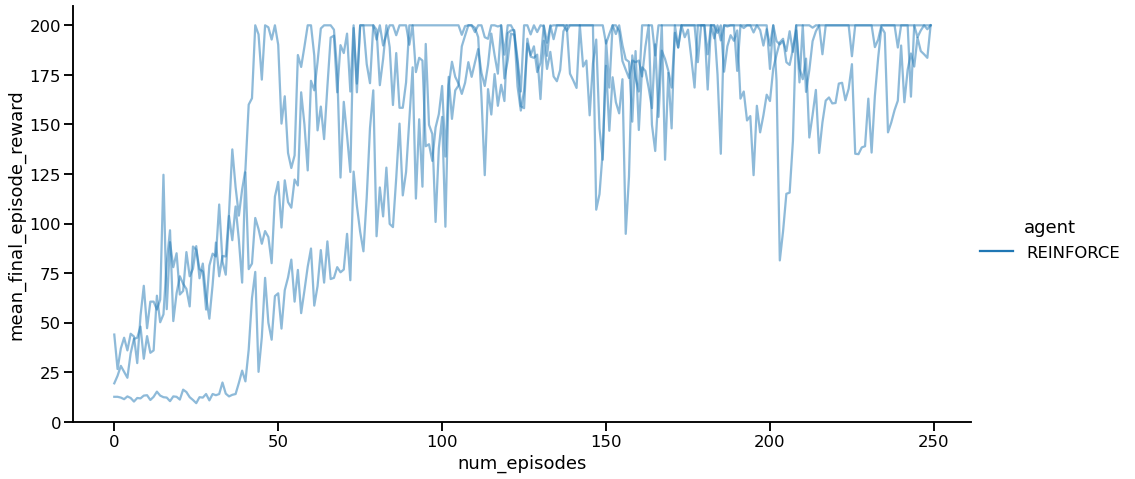

In [52]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=reinforce_trains_result_df, height=7, aspect=2, alpha=0.5)
plt.savefig("lab2_reinforce_cartpole_trains_result.png")

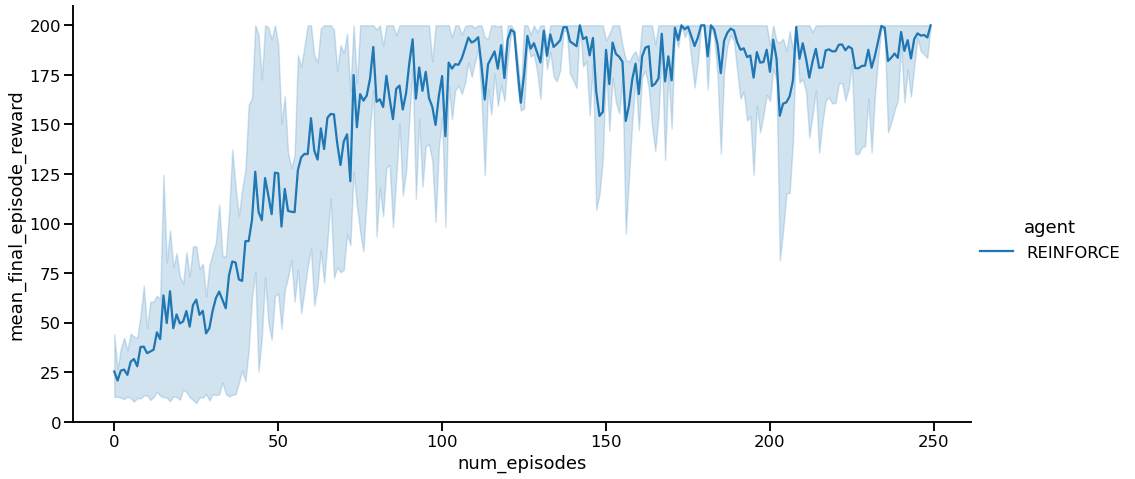

In [53]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_trains_result_df, height=7, aspect=2)
plt.savefig("lab2_reinforce_cartpole_trains_result_agg.png")

#### Test final policy

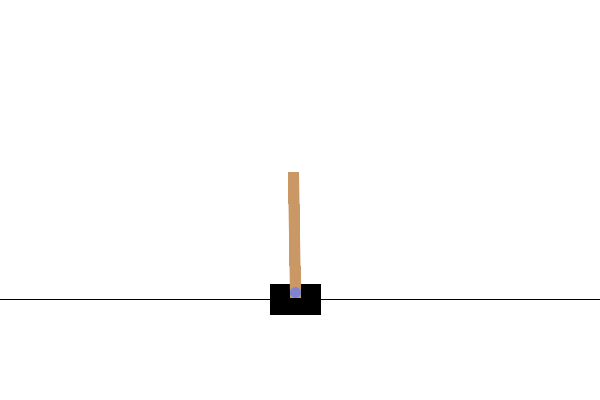

In [54]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, reinforce_policy_nn, 200, render=True)

env.close()
env.render_wrapper.make_gif("lab2_reinforce_tained")

**Task 1.9**: decrease the learning rate value (e.g. 0.001), increase the number of episodes per training and retrain the agent. What do you observe ?

In [55]:
# Retraining the agent with a lower value of the learning rate, with more episodes

env = gym.make('CartPole-v1')

num_trains = 3
reinforce_trains_result_list = [[], [], []]

for train_index in range(num_trains):

    # Train the agent
    reinforce_policy_nn, episode_reward_list = train_reinforce_discrete(env=env,
                                                                        num_train_episodes=500,
                                                                        num_test_per_episode=5,
                                                                        max_episode_duration=200,
                                                                        learning_rate=0.001)

    reinforce_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_trains_result_list[1].extend(episode_reward_list)
    reinforce_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_trains_result_df = pd.DataFrame(np.array(reinforce_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_trains_result_df["agent"] = "REINFORCE"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, "reinforce_policy_network.pth")


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

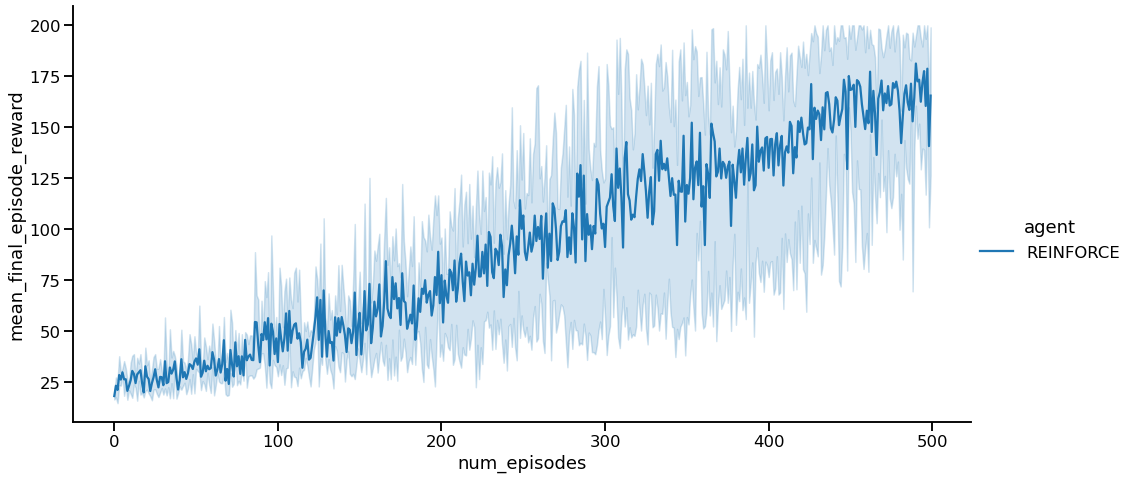

In [56]:
# Plot the results
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_trains_result_df, height=7, aspect=2)
plt.savefig("lab2_reinforce_cartpole_trains_result_agg.png")

**Observations:** As the learning rate is lower, we converge much slower than the first example. However, it seems more stable and might earn a higher mean reward if we train on more episodes.

**Personal Note:** GPU is not always good with RL, it depends on the number of samples you need, the number of parameters of the NN. In this case, there are a lot of data transfers between CPU and GPU, so it overall slows down the training process (that is why we forced `device=cpu`).

### Exercise 2: REINFORCE with Baseline

In the basic REINFORCE algorithm, the policy parameters are updated in proportion to the product of the gradient of the policy log-probability and the cumulative reward (return) from a state-action pair. However, this approach can lead to high variance in policy updates, making learning slower and less stable.

The baseline is introduced to reduce this variance. It is a value subtracted from the cumulative reward when calculating the policy gradient. The key property of the baseline is that it does not affect the expected value of the gradient estimate, which means it doesn't bias the learning process but reduces the variance of the updates.

The baseline can be thought of as a reference point or an "average" expectation of reward. By comparing the actual rewards to this baseline, we can determine whether the outcomes of certain actions are better or worse than this "average" performance.

A common choice for the baseline is the value function of the current policy, $\hat{V}_{\boldsymbol{\omega}}$. By using the value function as a baseline, the algorithm adjusts the policy towards actions that perform better than the average.

To incorporate the baseline into REINFORCE, you modify the update rule. Instead of using the total return $G$​ directly, you subtract the baseline value $\hat{V}_{\boldsymbol{\omega}}$ from $G$​ in the policy gradient estimate.

By centering the rewards around a baseline, the variance of the policy gradient estimates is reduced. This leads to more stable and efficient learning, as the updates are less noisy and more focused on improving relative to the average performance.

#### REINFORCE with Baseline

<b>REQUIRE</b> <br>
 $\quad$ A differentiable policy $\pi_{\boldsymbol{\theta}}$ <br>
 $\quad$ A differentiable baseline function $\hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s})$ <br>
 $\quad$ A learning rate $\alpha_1 \in \mathbb{R}^+$ for the policy <br>
 $\quad$ A learning rate $\alpha_2 \in \mathbb{R}^+$ for the baseline <br>
<b>INITIALIZATION</b> <br>
 $\quad$ Initialize parameters $\boldsymbol{\theta} \in \mathbb{R}^d$ <br>
 $\quad$ Initialize parameters $\boldsymbol{\omega} \in \mathbb{R}^d$ <br>
<br>
<b>FOR EACH</b> episode <br>
 $\quad$ Generate full trace $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$ following $\pi_{\boldsymbol{\theta}}$ <br>
 $\quad$ <b>FOR</b> $~ t=0,\dots,T-1$ <br>
  $\quad\quad$ $G \leftarrow \sum_{k=t}^{T-1} r_k$ <br>
  $\quad\quad$ $\delta_t \leftarrow G - \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s}_t)$ <br>
  $\quad\quad$ $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha_1 ~ \delta_t ~ \nabla_{\boldsymbol{\theta}} \ln \pi_{\boldsymbol{\theta}}(\boldsymbol{a}_t|\boldsymbol{s}_t)$ <br>
  $\quad\quad$ $\boldsymbol{\omega} \leftarrow \boldsymbol{\omega} + \alpha_2 ~ \delta_t \nabla_{\boldsymbol{\omega}}\hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s}_t) $ <br>
<br>
<b>RETURN</b> $\boldsymbol{\theta}$

Method semi gradient for TD0 livre pour voir pourquoi on uppdate NN V en multipliant par delta

**Task 1.10**: Implement the `ValueNetwork` ($\hat{V}_{\boldsymbol{\omega}}$ in the algorithm) defined as follow.

`ValueNetwork` is a two-layer fully connected neural network. It takes an input tensor representing the state of the environment and outputs a tensor representing the estimated value of that state. The input tensor's shape should be (N, dim), where N is the number of state vectors in the batch and dim is the dimension of the state vectors.

The network has the following components:
- `layer1`: This is a linear (fully connected) layer that takes `n_observations` as input and outputs `nn_l1` neurons.
- `layer2`: This is another linear layer that takes `nn_l1` neurons as input and outputs a single value.
- `forward` method: This method defines the forward pass of the network. It takes a state tensor as input and returns a tensor representing the estimated value of the state. It first applies the ReLU activation function to the output of the first layer, and then applies the second linear layer to get the final output.

This network is quite simple and may not perform well on complex tasks with large state spaces. However, it can be a good starting point for simple reinforcement learning tasks, and can be easily extended with more layers or different types of layers (such as convolutional layers for image inputs) to handle more complex tasks.

In [57]:
class ValueNetwork(torch.nn.Module):
    """
    A two-layer fully connected network that estimates the value of a state.

    Parameters
    ----------
    n_observations : int
        The number of observations in the state.
    nn_l1 : int, optional
        The number of neurons in the first layer, by default 16

    Attributes
    ----------
    layer1 : torch.nn.Linear
        The first fully connected layer.
    layer2 : torch.nn.Linear
        The second fully connected layer.
    """

    def __init__(self, n_observations: int, nn_l1: int = 16):
        super(ValueNetwork, self).__init__()

        ### BEGIN SOLUTION ###

        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, 1)

        ### END SOLUTION ###


    def forward(self, state_tensor: torch.Tensor) -> torch.Tensor:
        """
        Perform a forward pass through the network.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor representing the state.

        Returns
        -------
        torch.Tensor
            The output tensor representing the value of the state.

        """

        ### BEGIN SOLUTION ###

        state_tensor = torch.nn.functional.relu(self.layer1(state_tensor))
        x = self.layer2(state_tensor)

        ### END SOLUTION ###

        return x

#### Implement the train function

**Task 1.11**: Implement the `train_reinforce_baseline_discrete` function, used to train a policy network and a value network using the REINFORCE with baseline algorithm in a given environment.

The function first initializes a policy network and a value network, along with their respective Adam optimizers. Then, for each training episode, it generates an episode using the current policy and calculates the return at each time step. It uses this return, the log probability of the action taken at that time step, and the estimated value of the state to compute the policy and value losses. These losses are used to update the policy and value network parameters using gradient ascent. The value loss is typically defined as the squared difference between the estimated return and the actual return.

In [103]:
def train_reinforce_baseline_discrete(env: gym.Env,
                                      num_train_episodes: int,
                                      num_test_per_episode: int,
                                      max_episode_duration: int,
                                      policy_learning_rate: float,
                                      value_learning_rate: float) -> Tuple[PolicyNetwork, List[float]]:
    """
    Train a policy using the REINFORCE with baseline algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_train_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode.
    policy_learning_rate : float
        The policy learning rate.
    value_learning_rate : float
        The value learning rate.

    Returns
    -------
    Tuple[PolicyNetwork, List[float]]
        The final trained policy and the average returns for each episode.
    """
    episode_avg_return_list = []

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n.item()

    policy_nn = PolicyNetwork(state_size, action_size).to(device)
    policy_optimizer = torch.optim.Adam(policy_nn.parameters(), lr=policy_learning_rate)

    value_nn = ValueNetwork(state_size).to(device)
    value_optimizer = torch.optim.Adam(value_nn.parameters(), lr=value_learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):

        # Generate an episode following the current policy
        episode_state_list, _, episode_reward_list, episode_log_prob_action_list = sample_one_episode(env=env,
                                                                                                      policy_nn=policy_nn,
                                                                                                      max_episode_duration=max_episode_duration)

        ### BEGIN SOLUTION ###

        # Initialize the value_loss to 0 at the beginning of each episode
        value_loss = 0

        # Iterate over the episode
        for t in range(len(episode_reward_list)):
            # Calculate the return at time t
            future_return = np.sum(episode_rewards[t:])

            # Convert the future_return to a PyTorch tensor
            returns_tensor = torch.tensor(future_return, dtype=torch.float32, device=device)

            # Convert the episode_log_prob_action_list[t] to a PyTorch tensor
            log_prob_actions_tensor = episode_log_prob_action_list[t] # Already a list of tensors

            # Convert the episode_state_list[t] to a PyTorch tensor
            state_tensor = torch.tensor(episode_state_list[t], dtype=torch.float32, device=device)

            # Compute the baseline
            current_value = value_nn.forward(state_tensor)
            delta = (returns_tensor - current_value).item() # Convert to a number, and keep the log_prob as a tensor

            # Compute the policy loss
            policy_loss = -delta*log_prob_actions_tensor

            # Update the policy network
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # Accumulate the value_loss
            value_loss -= delta*current_value

        # Average the value_loss over the episode duration
        value_loss /= len(episode_reward_list)

        # Update the value network
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        ### END SOLUTION ###

        # Test the current policy
        test_avg_return = avg_return_on_multiple_episodes(env=env,
                                                          policy_nn=policy_nn,
                                                          num_test_episode=num_test_per_episode,
                                                          max_episode_duration=max_episode_duration,
                                                          render=False)

        # Monitoring
        episode_avg_return_list.append(test_avg_return)

    return policy_nn, episode_avg_return_list

#### Train the agent

In [104]:
env = gym.make('CartPole-v1')

num_trains = 3
reinforce_baseline_trains_result_list = [[], [], []]

for train_index in range(num_trains):

    # Train the agent
    reinforce_baseline_policy_nn, episode_reward_list = train_reinforce_baseline_discrete(env=env,
                                                                                          num_train_episodes=250,
                                                                                          num_test_per_episode=5,
                                                                                          max_episode_duration=200,
                                                                                          policy_learning_rate=0.02,
                                                                                          value_learning_rate=0.02)

    reinforce_baseline_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_baseline_trains_result_list[1].extend(episode_reward_list)
    reinforce_baseline_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_baseline_trains_result_df = pd.DataFrame(np.array(reinforce_baseline_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_baseline_trains_result_df["agent"] = "REINFORCE baseline"

# Save the action-value estimation function of the last train

torch.save(reinforce_baseline_policy_nn, "reinforce_baseline_policy_network.pth")

env.close()

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

#### Plot results

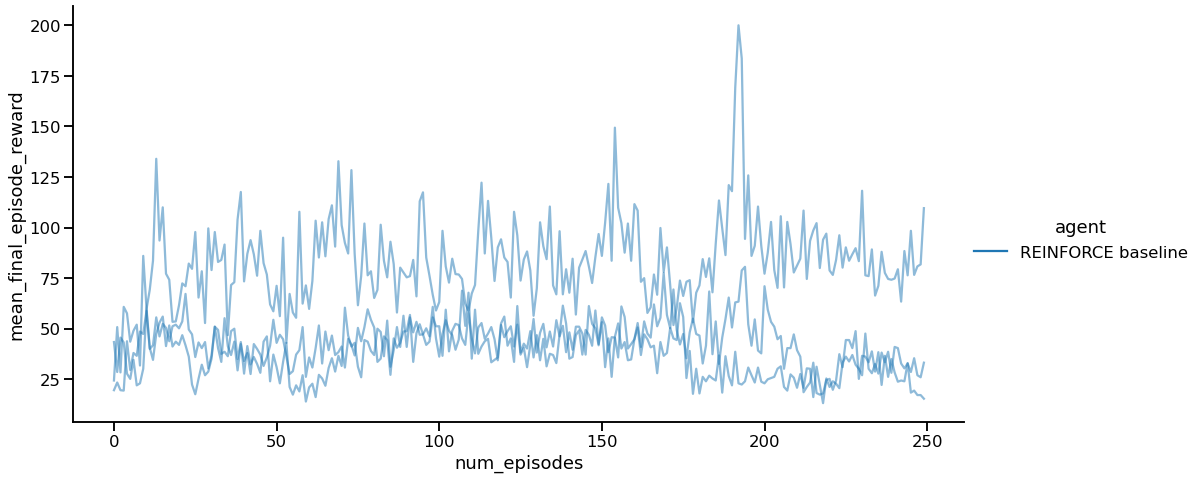

In [105]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=reinforce_baseline_trains_result_df, height=7, aspect=2, alpha=0.5)
plt.savefig("lab2_reinforce_cartpole_trains_result.png")

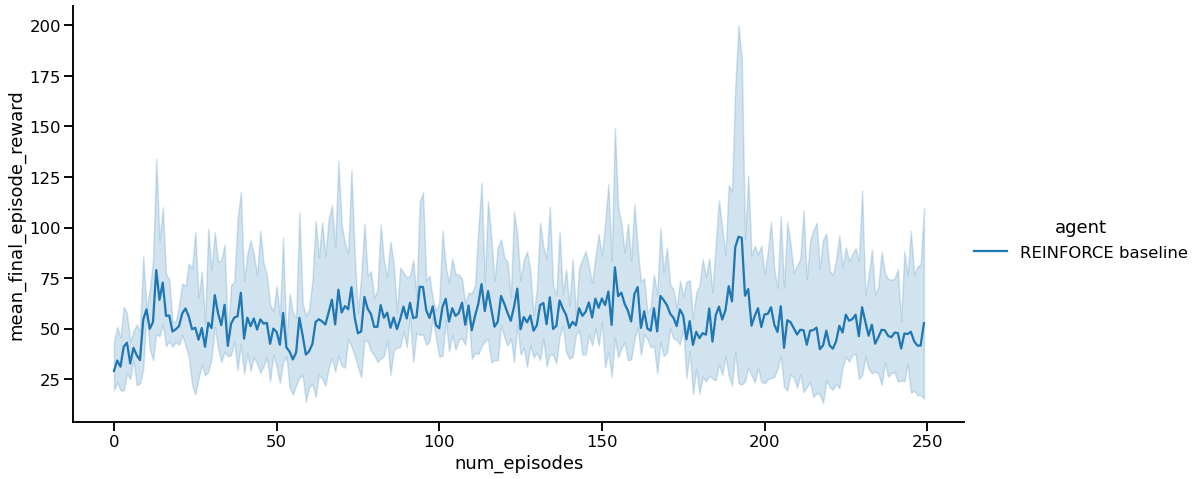

In [106]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_baseline_trains_result_df, height=7, aspect=2)
plt.savefig("lab2_reinforce_cartpole_trains_result_agg.png")

#### Test final policy

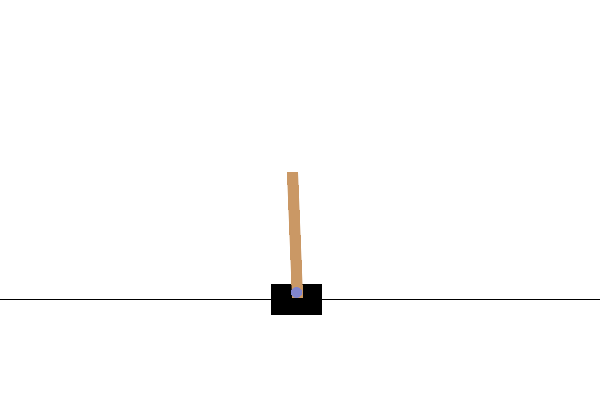

In [107]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, reinforce_policy_nn, 200, render=True)

env.close()
env.render_wrapper.make_gif("lab2_reinforce_tained")

**Observations:** I get worse results with REINFORCE (baseline) than with standard REIINFORCE. I see mainly two hypothesis:
- I implemented it badly, yet we did not find blatant mistakes with Jeremie last week
- The hyperparameters are not well tuned.

### Implementing an optimizer to find the best hyperparameters

In this part, I try to use **Optuna** to finetune the hyperparameters of the model. The optuna framework is quite simple as it allows to merely encapsulate our already implemented functions.

In [162]:
import optuna

In [172]:
# Implementing an optimizer for our hyperparameters

def objective(trial):

    env = gym.make('CartPole-v1')

    num_trains = 3
    reinforce_baseline_trains_result_list = [[], [], []]

    # We will finetune both the lr for the policy network and the other for the value network: we feed them to optuna
    policy_lr = trial.suggest_float("policy_learning_rate", 0.001, 0.04) # optimized within range [0.001, 0.04]
    value_lr = trial.suggest_float("value_learning_rate", 0.001, 0.04)
    
    for train_index in range(num_trains):

        # Train the agent
        reinforce_baseline_policy_nn, episode_reward_list = train_reinforce_baseline_discrete(env=env,
                                                                                            num_train_episodes=250,
                                                                                            num_test_per_episode=5,
                                                                                            max_episode_duration=200,
                                                                                            policy_learning_rate=policy_lr,
                                                                                            value_learning_rate=value_lr)
        trial.report(np.sum(episode_reward_list), train_index)
        
    env.close()

    return np.sum(episode_reward_list) ## return only the sum of the episoded played during the last train

In [173]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=600)

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-17 17:21:33,687] A new study created in memory with name: no-name-9bcde4d6-17da-4e35-a2e1-e968dbd9ef1f


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:22:12,804] Trial 0 finished with value: 7691.0 and parameters: {'policy_learning_rate': 0.008119778689727221, 'value_learning_rate': 0.018386082209175623}. Best is trial 0 with value: 7691.0.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:22:53,180] Trial 1 finished with value: 3446.6 and parameters: {'policy_learning_rate': 0.031376324254781575, 'value_learning_rate': 0.03514826879325609}. Best is trial 0 with value: 7691.0.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:23:45,295] Trial 2 finished with value: 11524.8 and parameters: {'policy_learning_rate': 0.03521428474859288, 'value_learning_rate': 0.030443291751535075}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:24:40,705] Trial 3 finished with value: 9090.0 and parameters: {'policy_learning_rate': 0.010612572843174652, 'value_learning_rate': 0.018046334386152937}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:25:46,127] Trial 4 finished with value: 7837.400000000001 and parameters: {'policy_learning_rate': 0.01206722137628979, 'value_learning_rate': 0.03780283626176717}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:26:19,623] Trial 5 finished with value: 8987.6 and parameters: {'policy_learning_rate': 0.017544418734350246, 'value_learning_rate': 0.0026690757632717647}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:27:04,476] Trial 6 finished with value: 6097.4 and parameters: {'policy_learning_rate': 0.022569190555006554, 'value_learning_rate': 0.029021339384664918}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:27:23,782] Trial 7 finished with value: 2988.7999999999997 and parameters: {'policy_learning_rate': 0.0061039369713555, 'value_learning_rate': 0.032684171056001424}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:27:55,906] Trial 8 finished with value: 5855.0 and parameters: {'policy_learning_rate': 0.0035759864596695244, 'value_learning_rate': 0.0018116647674993609}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:28:30,023] Trial 9 finished with value: 11304.6 and parameters: {'policy_learning_rate': 0.035264752926831115, 'value_learning_rate': 0.030634420059971485}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:28:56,175] Trial 10 finished with value: 2862.6 and parameters: {'policy_learning_rate': 0.027499778690606373, 'value_learning_rate': 0.024071213512459846}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:29:35,590] Trial 11 finished with value: 2895.0 and parameters: {'policy_learning_rate': 0.039068034369281496, 'value_learning_rate': 0.027205573231761204}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:30:43,337] Trial 12 finished with value: 10983.4 and parameters: {'policy_learning_rate': 0.0362509579775566, 'value_learning_rate': 0.03942493481694406}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:31:24,668] Trial 13 finished with value: 4128.200000000001 and parameters: {'policy_learning_rate': 0.030799950702754996, 'value_learning_rate': 0.009936632497822798}. Best is trial 2 with value: 11524.8.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-11-17 17:31:50,932] Trial 14 finished with value: 7570.0 and parameters: {'policy_learning_rate': 0.03384633123269743, 'value_learning_rate': 0.03112462083219383}. Best is trial 2 with value: 11524.8.


Study statistics: 
  Number of finished trials:  15
Best trial:
  Value:  11524.8
  Params: 
    policy_learning_rate: 0.03521428474859288
    value_learning_rate: 0.030443291751535075


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

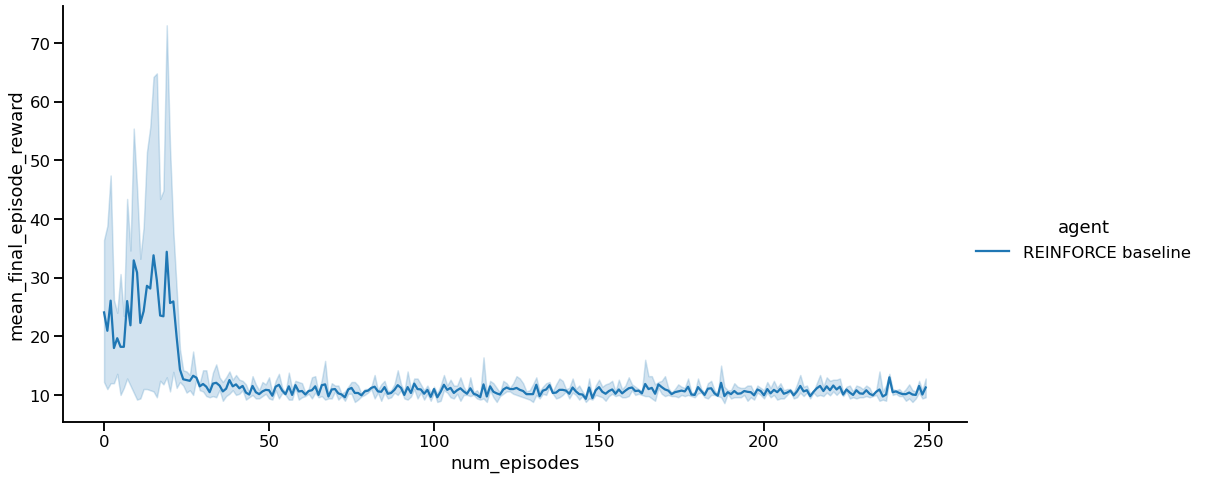

In [174]:
### TEST WITH THE FINAL SETTING

env = gym.make('CartPole-v1')

num_trains = 3
reinforce_baseline_trains_result_list = [[], [], []]

policy_lr = study.best_trial.params['policy_learning_rate']
value_lr = study.best_trial.params['value_learning_rate']
for train_index in range(num_trains):

    # Train the agent
    reinforce_baseline_policy_nn, episode_reward_list = train_reinforce_baseline_discrete(env=env,
                                                                                          num_train_episodes=250,
                                                                                          num_test_per_episode=5,
                                                                                          max_episode_duration=200,
                                                                                          policy_learning_rate=policy_lr,
                                                                                          value_learning_rate=value_lr)

    reinforce_baseline_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_baseline_trains_result_list[1].extend(episode_reward_list)
    reinforce_baseline_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_baseline_trains_result_df = pd.DataFrame(np.array(reinforce_baseline_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_baseline_trains_result_df["agent"] = "REINFORCE baseline"

# Save the action-value estimation function of the last train

torch.save(reinforce_baseline_policy_nn, "reinforce_baseline_policy_network.pth")

env.close()

g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_baseline_trains_result_df, height=7, aspect=2)
plt.savefig("lab2_reinforce_cartpole_trains_result_agg_optimized.png")

**Observations:** I get worse results with Optuna, but I may well not have implemented the whole framework. In the tutorial watched, a `model(trial)` encapsulates the definition of the network (see https://optuna.readthedocs.io/en/stable/tutorial/index.html).
However, I did not do it here as I do not want to fine tune the parameters of the network (dropout, ...), and this can be the source of my mistake. It is also possible that I did not run enough trials to optimize the parameters.

Also, I didn't try to prune not promising trials, which could really speed up the finetuning.

### Bonus Exercise: Implementing REINFORCE for Continuous Action Spaces (Lunar Lander)

The REINFORCE agent we've implemented so far is designed for environments with discrete action spaces. However, policy-based methods can effectively handle large, even continuous, action spaces. Instead of calculating learned probabilities for each possible action, we learn the statistics of the probability distribution. For instance, if the action set comprises real numbers, actions could be chosen from a normal (Gaussian) distribution.

To create a policy parameterization, we can define the policy as the normal probability density over a real-valued scalar action. The mean and standard deviation of this distribution are determined by parametric function approximators (the `PolicyNetwork` neural network) that depend on the state.

We can divide the policy’s parameter vector, $\boldsymbol{\theta} = [ \boldsymbol{\theta}_\mu, \boldsymbol{\theta}_\sigma ]^\top$, into two parts: one for approximating the mean and the other for approximating the standard deviation.

**Task 1.12**: Modify the `PolicyNetwork`, `sample_discrete_action`, and `train_reinforce_discrete` functions to make REINFORCE compatible with the *LunarLander-v2* environment. Remember to set `continuous=True` in the `gym.make` function.

In [201]:
class ContinuousPolicyNetwork(torch.nn.Module):
    """
    A neural network used as a policy for the REINFORCE algorithm.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        A fully connected layer.

    Methods
    -------
    forward(state: torch.Tensor) -> torch.Tensor
        Define the forward pass of the PolicyNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int):
        """
        Initialize a new instance of PolicyNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        """
        super(ContinuousPolicyNetwork, self).__init__()

        ### BEGIN SOLUTION ###

        # I take back the same architecture to compare the performances on discrete vs continuous action environments, but that may well be a bad idea
        self.layer1 = torch.nn.Linear(n_observations, n_actions, bias = False)

        ### END SOLUTION ###


    def forward(self, state_tensor: torch.Tensor) -> torch.Tensor:
        """
        Calculate the probability of each action for the given state.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor (state).
            The shape of the tensor should be (N, dim),
            where N is the number of states vectors in the batch
            and dim is the dimension of state vectors.

        Returns
        -------
        torch.Tensor
            The output tensor (the probability of each action for the given state).
        """

        ### BEGIN SOLUTION ###

        out = torch.nn.functional.softmax(self.layer1(state_tensor), dim=1) # We output the result between 0 and 1 for the sigma to be positive
                                                                        # We will then get the mean between -1 and 1 in the train function

        ### END SOLUTION ###

        return out

In [202]:
def sample_continuous_action(policy_nn: PolicyNetwork,
                           state: NDArray[np.float64]) -> Tuple[int, torch.Tensor]:
    """
    Sample a discrete action based on the given state and policy network.

    This function takes a state and a policy network, and returns a sampled action and its log probability.
    The action is sampled from a categorical distribution defined by the output of the policy network.

    Parameters
    ----------
    policy_nn : PolicyNetwork
        The policy network that defines the probability distribution of the actions.
    state : NDArray[np.float64]
        The state based on which an action needs to be sampled.

    Returns
    -------
    Tuple[int, torch.Tensor]
        The sampled action and its log probability.

    """

    ### BEGIN SOLUTION ###

    # Convert the state into a tensor, specify its data type as float32, and send it to the device (CPU or GPU).
    # The unsqueeze(0) function is used to add an extra dimension to the tensor to match the input shape required by the policy network.
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # Pass the state tensor through the policy network to get the parameters of the action probability distribution.
    actions_probability_distribution_params = policy_nn.forward(state_tensor)

    central_engine_distrib_params = actions_probability_distribution_params[0][:2]
    central_engine_distrib_params[0] = 2*central_engine_distrib_params[0] - 1 # shifting the mean to be between -1 and 1
    lateral_engine_distrib_params = actions_probability_distribution_params[0][2:]
    lateral_engine_distrib_params[0] = 2*lateral_engine_distrib_params[0] - 1 # shifting the mean to be between -1 and 1

    # Create the normal distributions used to sample an action from the parameters obtained from the policy network.
    central_engine_action_probability_distribution = torch.distributions.normal.Normal(central_engine_distrib_params[0], central_engine_distrib_params[1])
    lateral_engine_action_probability_distribution = torch.distributions.normal.Normal(lateral_engine_distrib_params[0], lateral_engine_distrib_params[1])
 
    # Sample an actions from the normal distributions
    sampled_action_central_engine_tensor = central_engine_action_probability_distribution.sample()
    sampled_action_lateral_engine_tensor = lateral_engine_action_probability_distribution.sample()

    # Convert the tensors containing the sampled action into a Python integer.
    sampled_action_central_engine = sampled_action_central_engine_tensor.item()
    sampled_action_lateral_engine = sampled_action_lateral_engine_tensor.item()
    sampled_action = (sampled_action_central_engine, sampled_action_lateral_engine)
    
    # Calculate the log probability of the sampled action according to the categorical distribution
    # Assuming independance in the activation of the lateral and central motors, we sum the log probabilities
    sampled_action_log_probability = central_engine_action_probability_distribution.log_prob(sampled_action_central_engine_tensor) + lateral_engine_action_probability_distribution.log_prob(sampled_action_lateral_engine_tensor)

    # Return the sampled action and its log probability.
    return sampled_action, sampled_action_log_probability

In [203]:
## Test the function with simple example

env = gym.make('LunarLander-v2', continuous=True)

state_size = env.observation_space.shape[0]
action_size = 4 #We want to get the params for 2 normals (central and lateral engines)


### BEGIN SOLUTION ###

test_policy_nn = ContinuousPolicyNetwork(state_size, action_size) # Initializing a policy
state = env.observation_space.sample() # Take a random state in the observation space
theta = test_policy_nn.state_dict()['layer1.weight']
action, action_log_probability = sample_continuous_action(test_policy_nn, state)

### END SOLUTION ###

print("state:", state)
print("theta:", theta)
print("sampled action:", action)
print("log probability of the sampled action:", action_log_probability)

env.close()

tensor([[0.0652, 0.0904, 0.0376, 0.8068]], grad_fn=<SoftmaxBackward0>)
state: [ 0.38994756  0.46476862  3.4992223   2.6975307  -1.9773611  -2.542116
  0.76470584  0.9529371 ]
theta: tensor([[ 0.1668, -0.2392, -0.0649,  0.0731,  0.1581, -0.2253, -0.2646, -0.0223],
        [-0.2051,  0.3233, -0.0174, -0.2089, -0.1636, -0.1163,  0.0880,  0.1621],
        [-0.0454,  0.2786, -0.3017, -0.2981, -0.1591, -0.3358,  0.2516, -0.2130],
        [ 0.2469, -0.0676,  0.3347,  0.2147, -0.1742, -0.0886,  0.2883, -0.1356]])
sampled action: (-0.9550706744194031, -0.37230658531188965)
log probability of the sampled action: tensor(0.0989, grad_fn=<AddBackward0>)


In [204]:
def train_reinforce_continuous(env: gym.Env,
                             num_train_episodes: int,
                             num_test_per_episode: int,
                             max_episode_duration: int,
                             learning_rate: float) -> Tuple[PolicyNetwork, List[float]]:
    """
    Train a policy using the REINFORCE algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_train_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode, by default EPISODE_DURATION.
    learning_rate : float
        The initial step size.

    Returns
    -------
    Tuple[PolicyNetwork, List[float]]
        The final trained policy and the average returns for each episode.
    """
    episode_avg_return_list = []

    state_size = env.observation_space.shape[0] # 8-dimensional for Lunar Lander
    action_size = 4 # We want to sample mu_central, sigma_central, mu_lateral, sigma_lateral to fire the engines

    policy_nn = ContinuousPolicyNetwork(state_size, action_size).to(device)
    optimizer = torch.optim.Adam(policy_nn.parameters(), lr=learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):

        ### BEGIN SOLUTION ###
        returns_timesteps = []
        
        episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, policy_nn, max_episode_duration)
        returns_timesteps = [np.sum(episode_rewards[i:]) for i in range(len(episode_rewards))]

        # Updating parameters for each timestep
        for timestep in range(len(episode_rewards)):
            G = returns_timesteps[timestep]
            log_prob = episode_log_prob_actions[timestep]
            loss = -G*log_prob

            # Compute deltaJ
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Test the current policy
        test_avg_return = avg_return_on_multiple_episodes(env=env,
                                                          policy_nn=policy_nn,
                                                          num_test_episode=num_test_per_episode,
                                                          max_episode_duration=max_episode_duration,
                                                          render=False)

        # Monitoring
        episode_avg_return_list.append(test_avg_return)

    return policy_nn, episode_avg_return_list

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

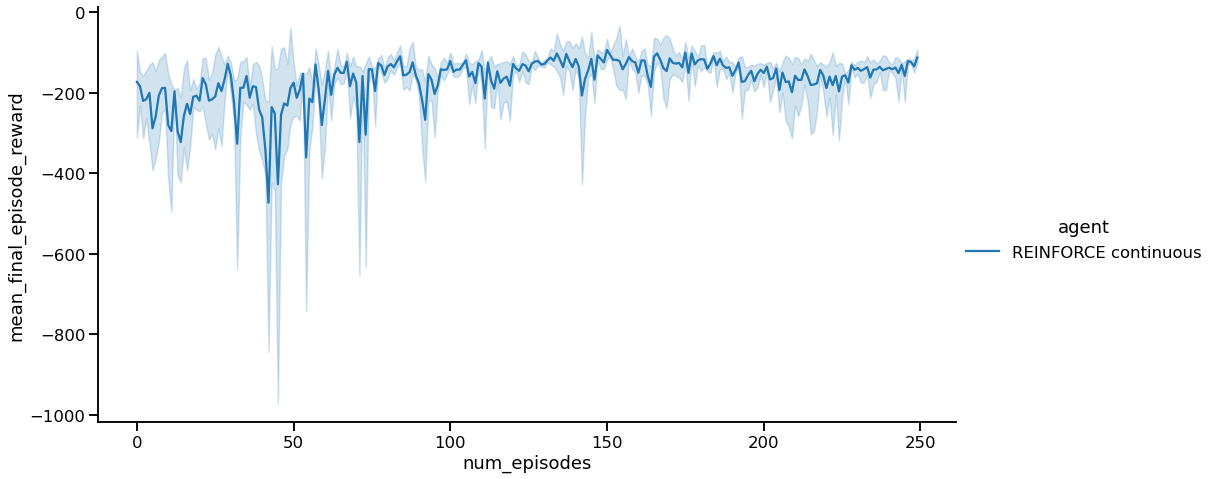

In [206]:
env = gym.make('LunarLander-v2')

num_trains = 3
reinforce_continuous_trains_result_list = [[], [], []]


for train_index in range(num_trains):

    # Train the agent
    reinforce_continuous_policy_nn, episode_reward_list = train_reinforce_continuous(env=env,
                                                                                          num_train_episodes=250,
                                                                                          num_test_per_episode=5,
                                                                                          max_episode_duration=300,
                                                                                          learning_rate=0.02)

    reinforce_continuous_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_continuous_trains_result_list[1].extend(episode_reward_list)
    reinforce_continuous_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_continuous_trains_result_df = pd.DataFrame(np.array(reinforce_continuous_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_continuous_trains_result_df["agent"] = "REINFORCE continuous"

# Save the action-value estimation function of the last train

torch.save(reinforce_continuous_policy_nn, "reinforce_continuous_policy_network.pth")

env.close()

g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_continuous_trains_result_df, height=7, aspect=2)
plt.savefig("lab2_reinforce_cartpole_trains_result_agg_optimized.png")

**Observation:** My results are not good (definitely not my day...), but here I think this is due to my modeling choices. For the `ContinuousPolicyNN`, I don't set any hidden layer, and I output after a softmax (to get my results between 0 and 1) 4 parameters (the mean and std deviation of the Gaussian for the middle motor, and the same for the side motors as the action space is made up of 2 box2d between -1 and 1, and I then apply 2*mu -1 to bring the mean between -1 and 1). Furthermore, to get the total log-proba, I sum the two log-probas from my normal laws, which only works if it's independent (which I'm not sure it is). 

## Part 2: Actor Critic

In the realm of Reinforcement Learning (RL), Actor-Critic methods stand out due to their widespread usage and effectiveness. These algorithms have become a staple in modern RL applications.

Previously, we explored the utilization of a value function approximation in the context of REINFORCE, primarily to mitigate variance. However, it's crucial to note that this approach did not constitute an Actor-Critic method. The value function in that scenario acted merely as a baseline and did not directly influence policy decisions.

In this section, we'll delve into the implementation of a standard Actor-Critic algorithm. This algorithm can be used as a stepping stone for developing more advanced Actor Critic algorithms.

### Actor Critic with bootstrapping

<b>REQUIRE</b> <br>
 $\quad$ A policy $\pi_{\boldsymbol{\theta}}$ and a value function $V_{\boldsymbol{\omega}}$ <br>
 $\quad$ A learning rate $\alpha_1$ for the critic and $\alpha_2$ for the actor <br>
<b>INITIALIZATION</b> <br>
 $\quad$ $\boldsymbol{\theta} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_n)$ <br>
 $\quad$ $\boldsymbol{\omega} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_n)$ <br>
<br>
<b>FOR EACH</b> episode <br>
 $\quad$ $\boldsymbol{s} \leftarrow \text{env.reset}()$ <br>
 $\quad$ <b>DO</b> <br>
  $\quad\quad$ $\boldsymbol{a} \sim \pi_{\boldsymbol{\theta}}(\cdot | \boldsymbol{s})$ <br>
  $\quad\quad$ $r, \boldsymbol{s'} \leftarrow \text{env.step}(\boldsymbol{a})$ <br>
  $\quad\quad$ $\boldsymbol{\omega} \leftarrow \boldsymbol{\omega} + \alpha_1 \left[ r + \gamma \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s'}) - \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s}) \right] \nabla_{\boldsymbol{\omega}} \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s})$ <br>
  $\quad\quad$ $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha_2 \left[ \nabla_{\boldsymbol{\theta}} ~ \ln \pi_{\boldsymbol{\theta}}(\boldsymbol{a}|\boldsymbol{s}) \times \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s}) \right]$ <br>
  $\quad\quad$ $\boldsymbol{s} \leftarrow \boldsymbol{s'}$ <br>
 $\quad$ <b>UNTIL</b> $\boldsymbol{s}$ is final <br>
<br>
<b>RETURN</b> $\boldsymbol{\theta}$ <br>

### Bonus Exercise: Implementing the simple Actor Critic algorithm to solve the Cartpole problem

**Task**: Implement the Actor Critic algorithm presented above to solve the Cartpole problem

We will reuse the `PolicyNetwork` and `ValueNetwork` classes to initialize our networks

In [110]:
from typing import Callable

### Train function

In [143]:
## Train function

def train_actor_critic(env: gym.Env,
                        value_loss_fn: Callable,
                        num_train_episodes: int,
                        max_episode_duration: int,
                        num_test_per_episode:int,
                        policy_learning_rate: float,
                        value_learning_rate: float,
                        gamma:float ) -> Tuple[PolicyNetwork, List[float]]:
    """
    Train a policy using the ACTOR CRITIC algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    value_loss_fn: Callable
        The loss function for the value network
    num_train_episodes : int
        The number of training episodes.
    max_episode_duration : int
        The maximum length of an episode.
    policy_learning_rate : float
        The policy learning rate.
    value_learning_rate : float
        The value learning rate.
    gamma: float
        The discount factor for future rewards.

    Returns
    -------
    Tuple[PolicyNetwork, List[float]]
        The final trained policy and the average returns for each episode.
    """

    debug = False

    # Initialization
    episode_avg_return_list = []

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n.item()

    # Initializing Policy and Value Networks
    policy_nn = PolicyNetwork(state_size, action_size).to(device) # Already initialized with a xavier_normal function
    policy_optimizer = torch.optim.Adam(policy_nn.parameters(), lr=policy_learning_rate)

    value_nn = ValueNetwork(state_size).to(device)
    value_optimizer = torch.optim.Adam(value_nn.parameters(), lr=value_learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):
        state, info = env.reset()
        t = 0
        terminated, truncated = False, False

        while(t<max_episode_duration and not(terminated or truncated)):

            action, action_log_proba = sample_discrete_action(policy_nn, state)
            if(debug):
                print(f'action is {action}')
                print(f'log_prob {action_log_proba}')

            next_state, reward, terminated, truncated, info = env.step(action)

            if(debug):
                print(f'next_state is {next_state}')
                print(f'reward {reward}')
            
            # Convert to tensors
            with torch.no_grad():
                # Convert the next_state to a Pytorch Tensor and add a batch dimension (unsqueeze)
                state_tensor = torch.tensor(state, dtype= torch.float32, device=device).unsqueeze(0)
                next_state_tensor = torch.tensor(next_state, dtype= torch.float32, device=device).unsqueeze(0)
                if(debug):
                    print(f'state_tensor is {state_tensor}')
                    print(f'next_state_tensor: {next_state_tensor}')

            current_value_estimate = value_nn.forward(state_tensor)
            next_value_estimate = value_nn.forward(next_state_tensor)
            if(debug):
                print(f'current_value_estimate is {current_value_estimate}')
                print(f'next_value_estimate: {next_value_estimate}')
            
            target_value = reward + gamma*next_value_estimate
            
            value_loss = value_loss_fn(current_value_estimate, target_value)
            if(debug):
                print(f'value_loss: {value_loss}')

            policy_loss = -current_value_estimate.item()*action_log_proba # Taking the float value of current_value_estimate to avoid problems in backward pass
            if(debug):
                print(f'policy_loss {policy_loss}')
            # Update the policy network
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # Update the value network
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            state = next_state
            t += 1
        # Test the current policy
        test_avg_return = avg_return_on_multiple_episodes(env=env,
                                                          policy_nn=policy_nn,
                                                          num_test_episode=num_test_per_episode,
                                                          max_episode_duration=max_episode_duration,
                                                          render=False)

        # Monitoring
        episode_avg_return_list.append(test_avg_return)

    return policy_nn, episode_avg_return_list

### Train the agent

In [157]:
env = gym.make('CartPole-v1')

value_loss_fn = torch.nn.MSELoss()
num_trains = 3
actor_critic_trains_result_list = [[], [], []]

for train_index in range(num_trains):

    # Train the agent
    actor_critic_policy_nn, episode_reward_list = train_actor_critic(env=env,
                                                                           value_loss_fn=value_loss_fn,
                                                                                          num_train_episodes=250,
                                                                                          num_test_per_episode=5,
                                                                                          max_episode_duration=200,
                                                                                          policy_learning_rate=0.02,
                                                                                          value_learning_rate=0.02, 
                                                                                          gamma= 0.9)

    actor_critic_trains_result_list[0].extend(range(len(episode_reward_list)))
    actor_critic_trains_result_list[1].extend(episode_reward_list)
    actor_critic_trains_result_list[2].extend([train_index for _ in episode_reward_list])

actor_critic_trains_result_df = pd.DataFrame(np.array(actor_critic_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
actor_critic_trains_result_df["agent"] = "ACTOR_CRITIC"

# Save the action-value estimation function of the last train

torch.save(actor_critic_policy_nn, "actor_critic_policy_network.pth")

env.close()

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

### Plot the results

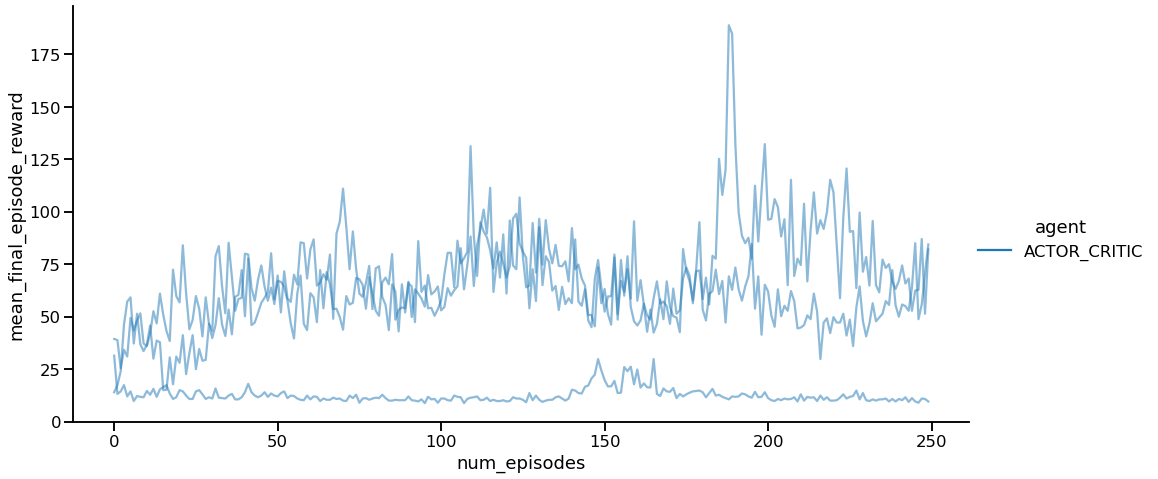

In [158]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=actor_critic_trains_result_df, height=7, aspect=2, alpha=0.5)
plt.savefig("lab2_actor_critic_cartpole_trains_result.png")

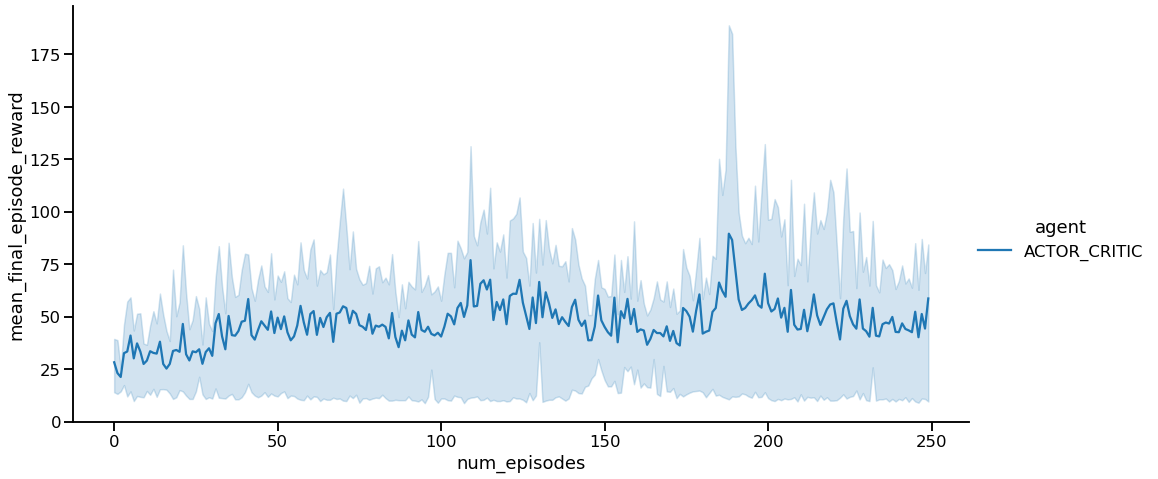

In [159]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=actor_critic_trains_result_df, height=7, aspect=2)
plt.savefig("lab2_actor_critic_cartpole_trains_result_agg.png")

**Observations:** Here again, I think that the hyperparameters are not correctly set. Maybe using Optuna will help me get better results.